# Comparison of generative models from Lorenz 63 attractors
## generative models:
* GAN: Lipschitz regularized $\alpha$ divergences ($W_1$ proximal regularized $\alpha$ divergences) or unregularized $\alpha$ divergences
    * KL-Lip=1, $\alpha=2$-Lip=1 or KL, $\alpha=2$
* GPA: Lipschitz regularized $\alpha$ divergences ($W_1$ proximal regularized $\alpha$ divergences) or unregularized $\alpha$ divergences
    * KL-Lip=1, $\alpha=2$-Lip=1 or KL, $\alpha=2$
* OT Flow: $W_2$ proximal regularized reverse KL
* CNF: unregularized reverse KL
* VE SGM (Variance Exploding SDE): $W_2$ proximal regularized Cross Entropy


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

vis_dir = "./assets/Lorenz63/visualizations/"
if not os.path.exists(vis_dir):
    os.makedirs(vis_dir)

## Validation data

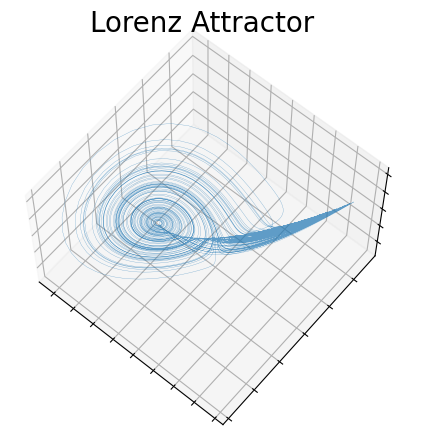

In [2]:
"""
================
Lorenz attractor
================

This is an example of plotting Edward Lorenz's 1963 `"Deterministic Nonperiodic
Flow"`_ in a 3-dimensional space using mplot3d.

.. _"Deterministic Nonperiodic Flow":
   https://journals.ametsoc.org/view/journals/atsc/20/2/1520-0469_1963_020_0130_dnf_2_0_co_2.xml

.. note::
   Because this is a simple non-linear ODE, it would be more easily done using
   SciPy's ODE solver, but this approach depends only upon NumPy.
"""

import matplotlib.pyplot as plt
import numpy as np


def lorenz(xyz, *, s=10, r=28, b=8/3):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])


dt = 0.01#0.01
num_steps = 1000000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (1.0,2.0,2.0)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(projection='3d')
#ax.set_axis_off()
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.set_title("Lorenz Attractor", fontsize=20)
ax.plot(*xyzs[-10000:].T, lw=0.2, alpha=0.7, c="tab:blue")
ax.view_init(elev=62, azim=130, roll=0)

plt.show()


## metrics
* MSE
* Adapted correlation dimension

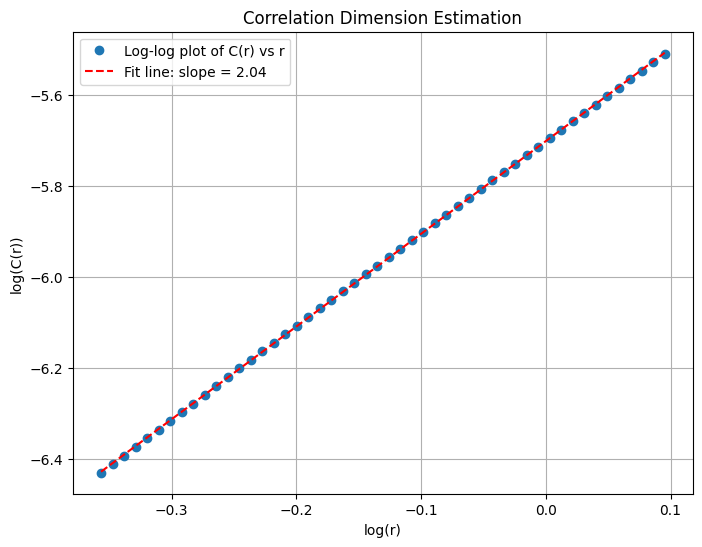

In [3]:
def mse(generated):
    d = 0
    for sample in generated:
        distances = np.linalg.norm(sample-xyzs[-10000:], axis = 1)
        d += min(distances)**2
    return d/generated.shape[0]

from Lorenz63.correlation_dimension import estimate_correlation_dimension
radii, correlation_sum, dimension_estimate = estimate_correlation_dimension(xyzs[-10000:], min_radius=0.7, max_radius=1.1)

## Visualization

In [4]:
from IPython.display import Image, display
import matplotlib.animation as animation

def make_animation(generated, ttl):
    fig = plt.figure(figsize=[5,5])
    ax = fig.add_subplot(projection='3d')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    
    ax.set_title(ttl)
    ims = []

    batchsize = 500
    for i in range(int(generated.shape[0]/batchsize)):
        line = ax.plot(*xyzs[-10000:].T, lw=0.2, alpha=0.7, c="tab:blue", zorder = 1)
        scatter = ax.scatter(generated[batchsize*i:batchsize*(i+1),0],generated[batchsize*i:batchsize*(i+1),1],generated[batchsize*i:batchsize*(i+1),2],\
                             s=0.2, c='r', alpha=1.0, zorder = 10)
        if i == 0:
            L=ax.legend(['attractor', 'generated samples'], bbox_to_anchor=(0.97, 1.00))
            ax.add_artist(L)
        ims.append(line + [scatter])
    fig.subplots_adjust(left=0, bottom=0, right=1, top=0.95, wspace=None, hspace=None)
    
    
    ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True, repeat_delay=1000)
    
    writergif = animation.PillowWriter(fps=3)
    ani.save(vis_dir + ttl.replace(" ", "_")+"_Lorenz63-movie.gif", writer=writergif)
    display(Image(filename = vis_dir + ttl.replace(" ", "_")+"_Lorenz63-movie.gif"))

def make_figure(generated, ttl, angles=[]):
    fig = plt.figure(figsize=[5,5.5])
    ax = fig.add_subplot(projection='3d')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    ttl_ = ttl.split("(")
    
    ax.set_title(ttl_[0], fontsize=23)

    ax.plot(*xyzs[-10000:].T, lw=0.2, alpha=0.7, c="tab:blue", zorder = 1)
    ax.scatter(generated[:,0],generated[:,1],generated[:,2],\
                             s=0.2, c='r', alpha=1.0, zorder = 10)
    fig_title = ttl.replace(" ", "_")+"_Lorenz63-figure.png"
    fig_title = fig_title.replace("(", "_")
    fig_title = fig_title.replace(")", "_")
    if len(angles) == 3: 
        ax.view_init(elev=angles[0], azim =angles[1], roll=angles[2])
        written_angle = "angles_%d_%d_%d" % (angles[0], angles[1], angles[2])
        fig_title = written_angle + fig_title
    #ax.legend(['attractor', 'generated samples'], bbox_to_anchor=(0.97, 1.00))
    fig.subplots_adjust(left=0, bottom=0, right=1, top=0.95, wspace=None, hspace=None)
    
    plt.savefig(vis_dir + fig_title)
    plt.show()

## Results

### $\alpha$-Lip GAN vs $\alpha$ GAN

$$\inf_{T:\mathbb{R}^{d'} \rightarrow \mathbb{R}^d} D_\alpha(T_\# P \|Q) + L \cdot W_1(P, R)$$
vs
$$\inf_{T:\mathbb{R}^{d'} \rightarrow \mathbb{R}^d} D_\alpha(T_\# P\|Q)$$

5000 samples


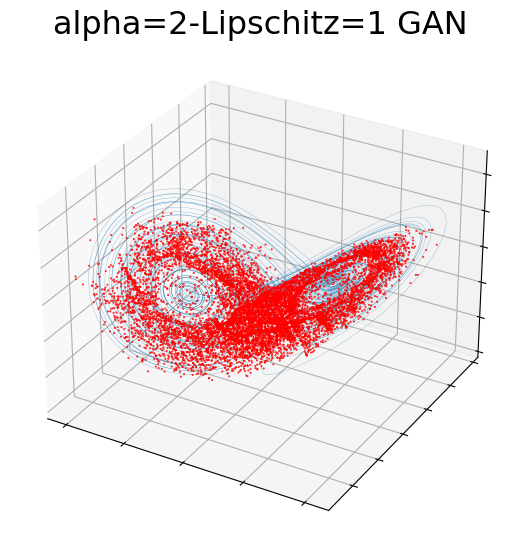

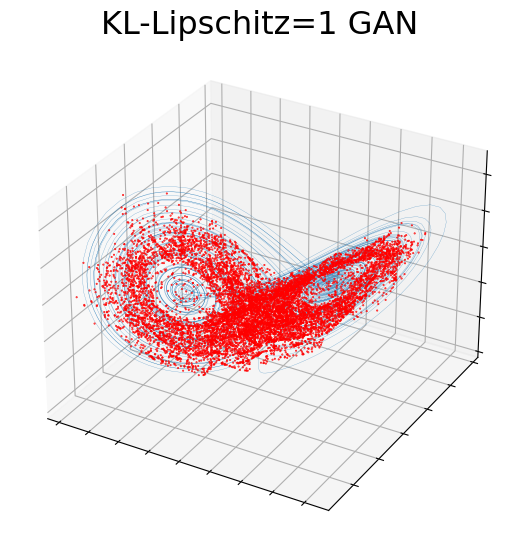

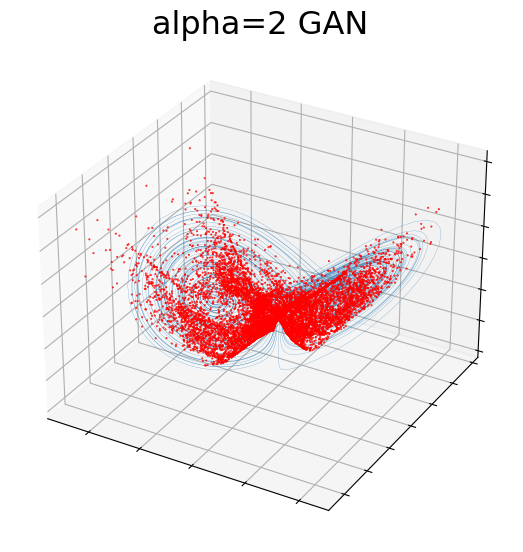

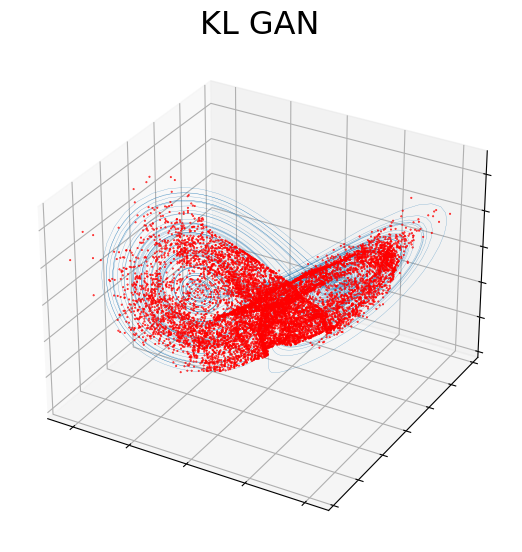

1000 samples


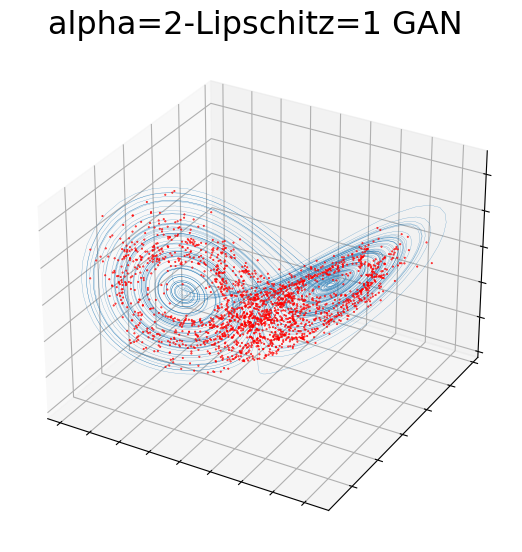

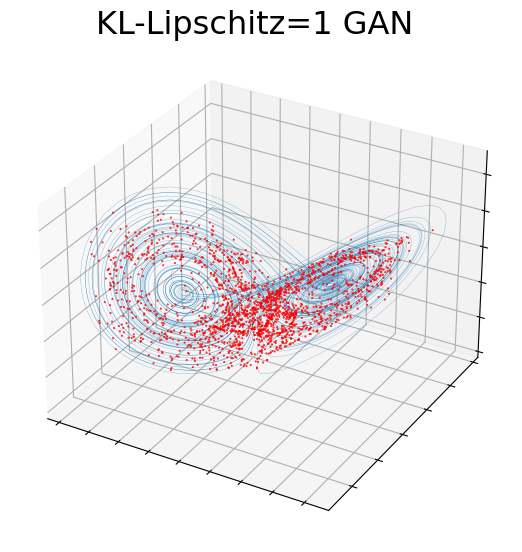

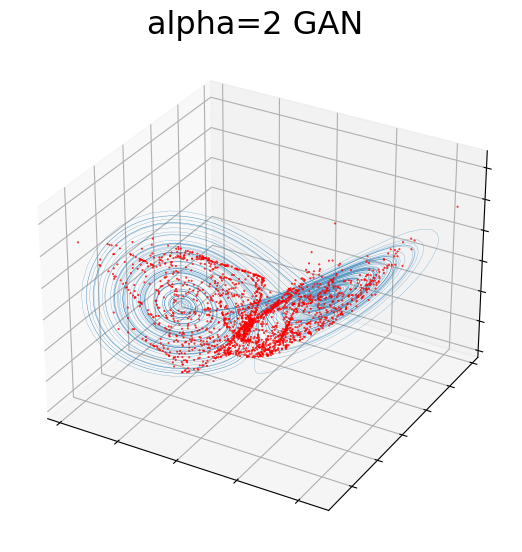

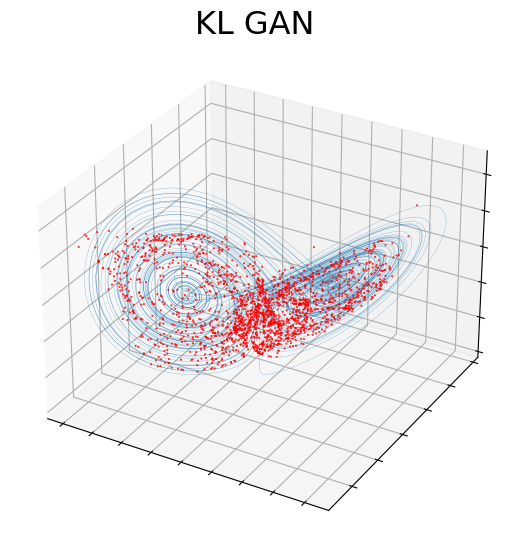

In [5]:
Ds = ['alpha=02.00-Lipschitz_1.0000', 'KL-Lipschitz_1.0000', 'alpha=02.00-Lipschitz_inf', 'KL-Lipschitz_inf']
D_names = ["alpha=2-Lipschitz=1 GAN", "KL-Lipschitz=1 GAN", "alpha=2 GAN", "KL GAN"]

print("5000 samples")
for D, D_name in zip(Ds, D_names):
    filename = "assets/Lorenz63/%s_GAN_5000samples_0_50000.pickle" % (D)
    with open(filename, "rb") as fr:
        [generated] = pickle.load(fr)
    
    #make_animation(generated, D_name)
    make_figure(generated, D_name)
    #make_figure(generated, D_name, [62,130, 0])
    #make_figure(generated, D_name, [119,120, 0])

print("1000 samples")
for D, D_name in zip(Ds, D_names):
    filename = "assets/Lorenz63/%s_GAN_1000samples_0_50000.pickle" % (D)
    with open(filename, "rb") as fr:
        [generated] = pickle.load(fr)
    
    #make_animation(generated, D_name)
    make_figure(generated, D_name +  " (1000 samples)")
    #make_figure(generated, D_name, [62,130, 0])
    #make_figure(generated, D_name, [119,120, 0])



5000 samples
alpha=2-Lipschitz=1 GAN: MSE=0.12409546535969343


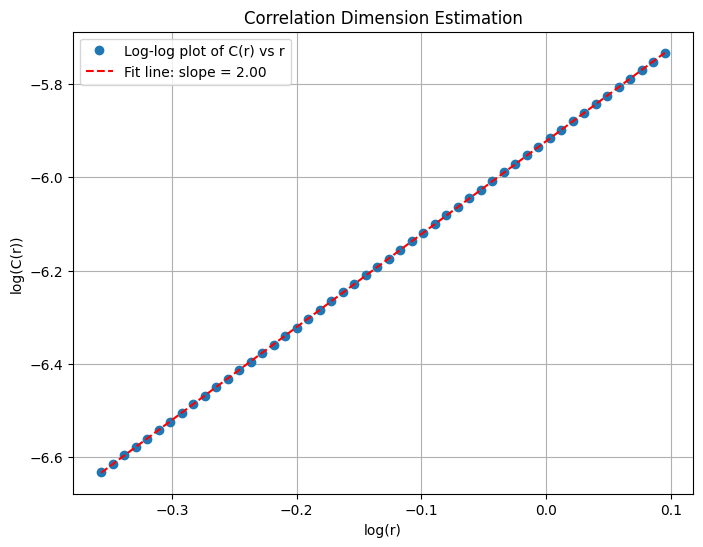

KL-Lipschitz=1 GAN: MSE=0.12269306002151366


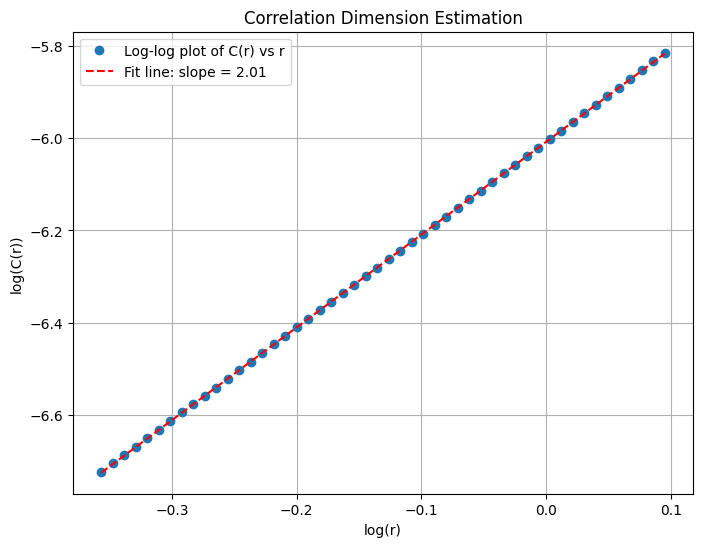

alpha=2 GAN: MSE=0.9450737894533459


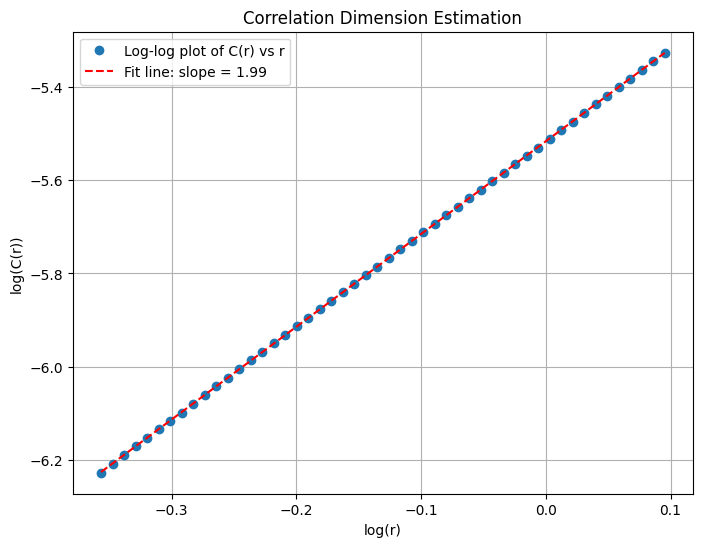

KL GAN: MSE=0.16127639953530265


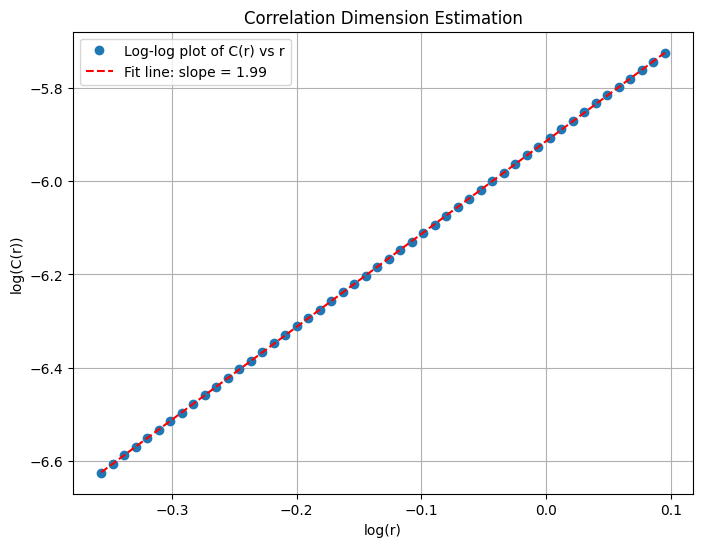

1000 samples
alpha=2-Lipschitz=1 GAN: MSE=0.12813027427377627


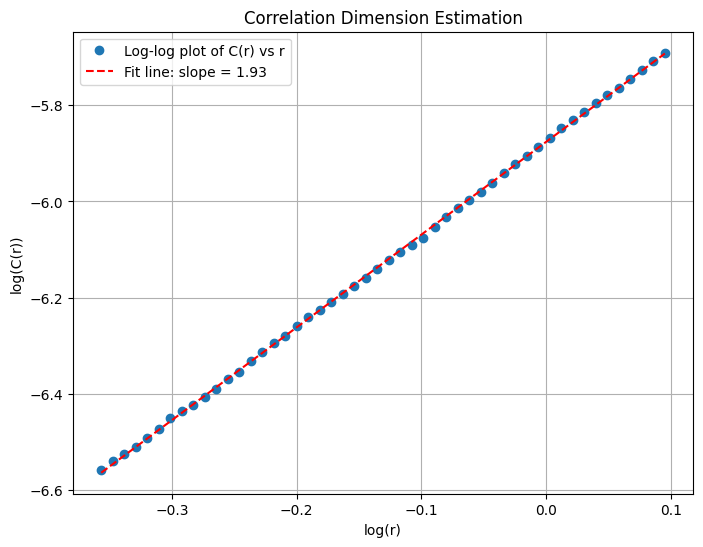

KL-Lipschitz=1 GAN: MSE=0.13270476599349013


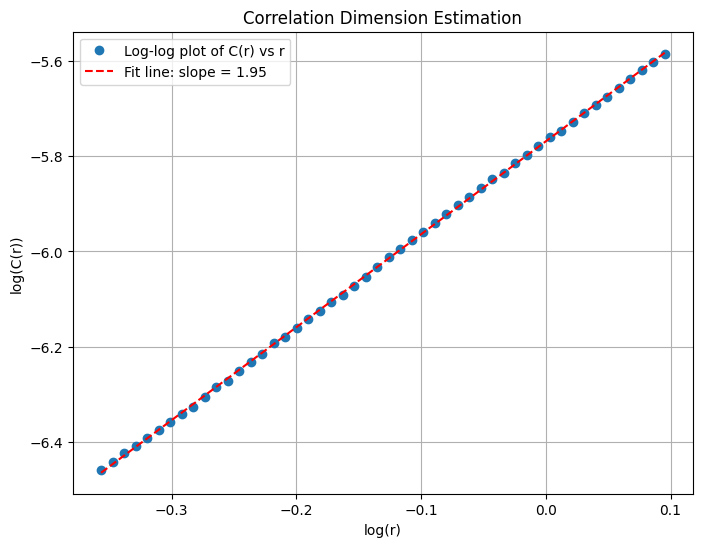

alpha=2 GAN: MSE=0.8801463568022144


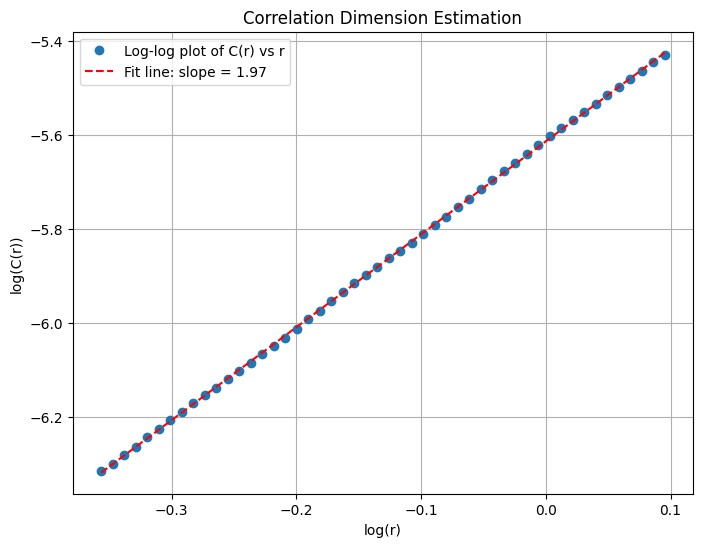

KL GAN: MSE=0.15060025192318452


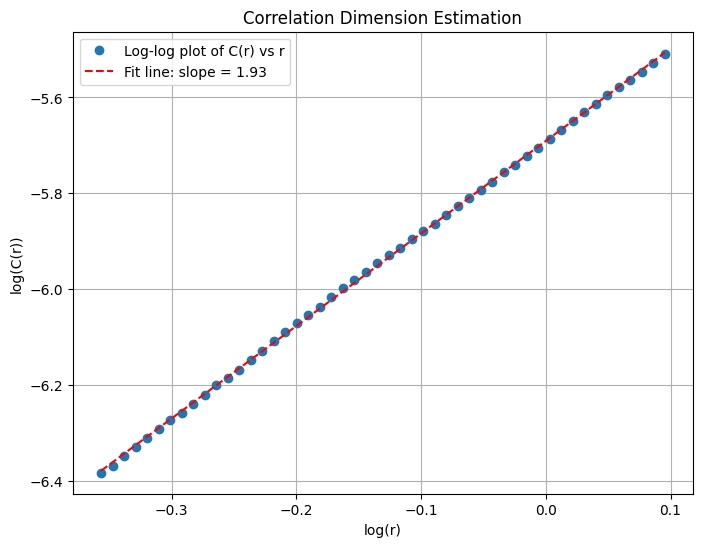

In [6]:
Ds = ['alpha=02.00-Lipschitz_1.0000', 'KL-Lipschitz_1.0000', 'alpha=02.00-Lipschitz_inf', 'KL-Lipschitz_inf']
D_names = ["alpha=2-Lipschitz=1 GAN", "KL-Lipschitz=1 GAN", "alpha=2 GAN", "KL GAN"]

print("5000 samples")
for D, D_name in zip(Ds, D_names):
    filename = "assets/Lorenz63/%s_GAN_5000samples_0_50000.pickle" % (D)
    with open(filename, "rb") as fr:
        [generated] = pickle.load(fr)

    print(f"{D_name}: MSE={mse(generated)}")
    radii, correlation_sum, dimension_estimate = estimate_correlation_dimension(generated, min_radius=0.7, max_radius=1.1)

print("1000 samples")
for D, D_name in zip(Ds, D_names):
    filename = "assets/Lorenz63/%s_GAN_1000samples_0_50000.pickle" % (D)
    with open(filename, "rb") as fr:
        [generated] = pickle.load(fr)

    print(f"{D_name}: MSE={mse(generated)}")
    radii, correlation_sum, dimension_estimate = estimate_correlation_dimension(generated, min_radius=0.7, max_radius=1.1)


### $\alpha$-Lip GPA vs $\alpha$ GPA

$$\inf_{R_t} D_\alpha(R_t \|Q) + L \cdot W_1(P_t, R_t)$$
vs
$$\inf_{R_t} D_\alpha(R_t \|Q)$$

5000 samples


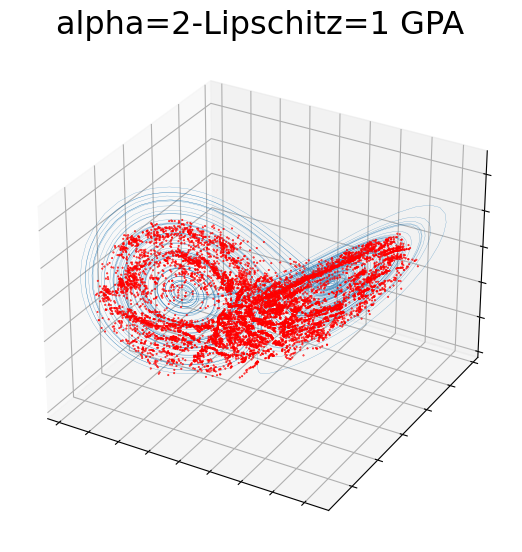

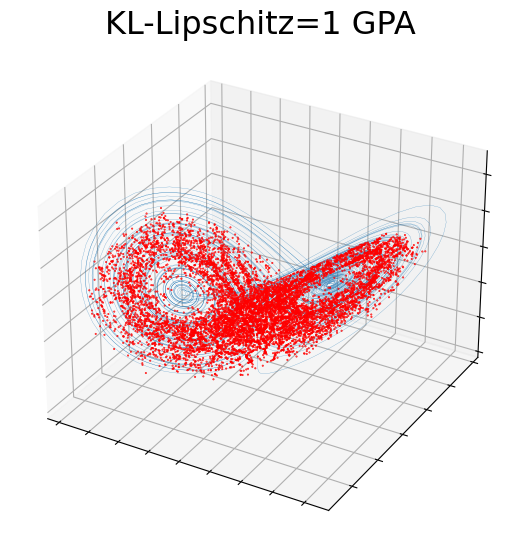

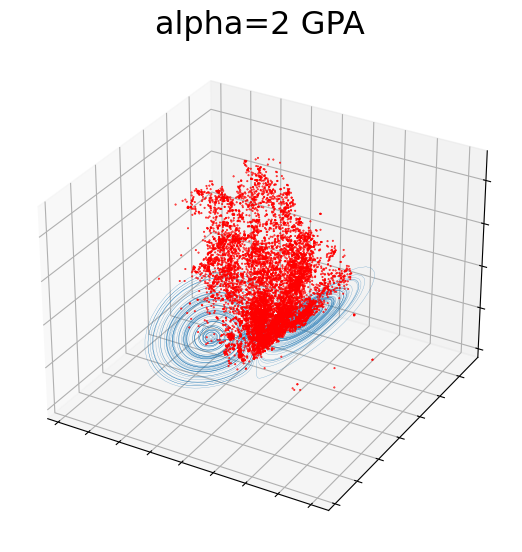

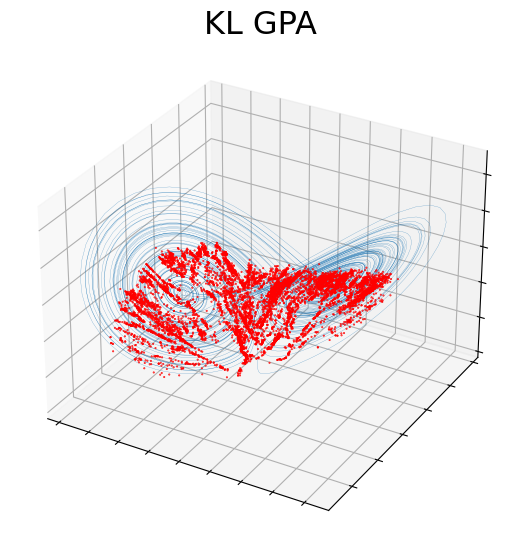

1000 samples


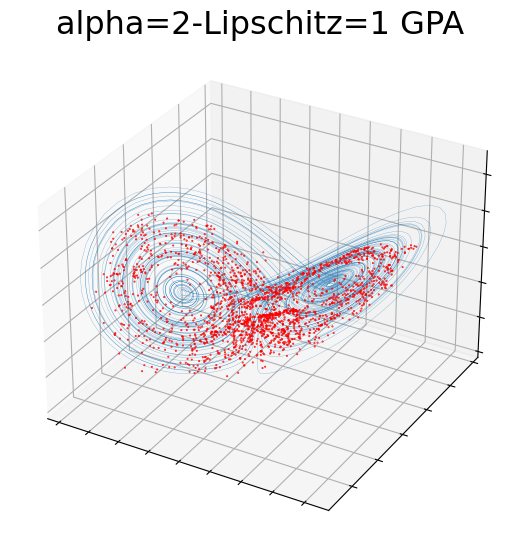

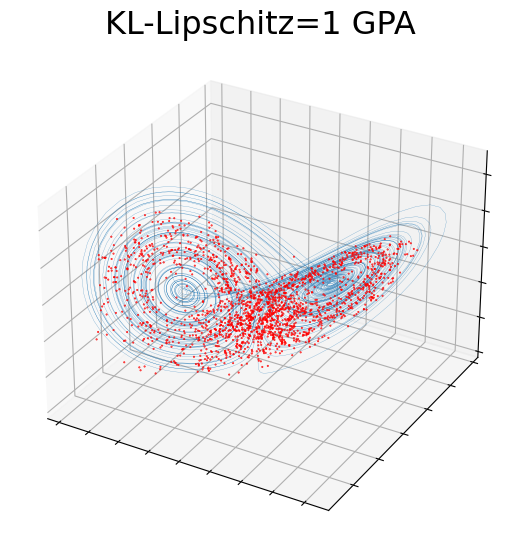

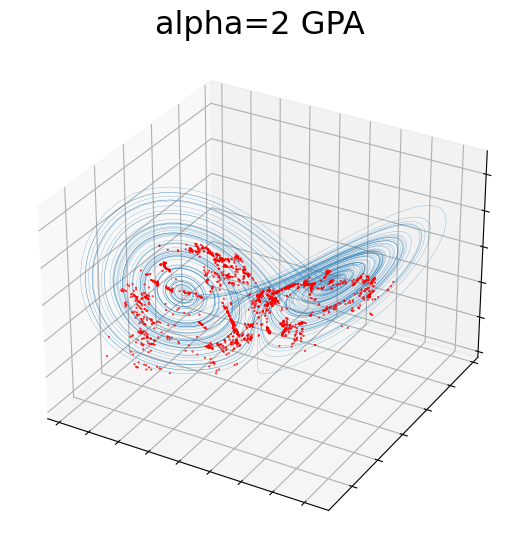

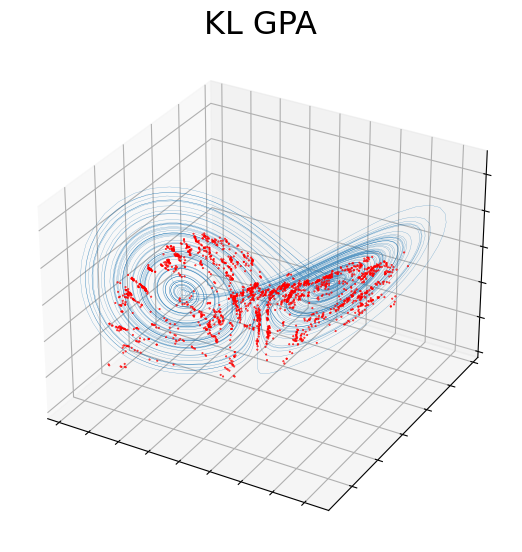

In [7]:
Ds = ['alpha=02.00-Lipschitz_1.0000', 'KL=02.00-Lipschitz_1.0000', 'alpha=02.00-Lipschitz_inf', 'KL=02.00-Lipschitz_inf']
D_names = ["alpha=2-Lipschitz=1 GPA", "KL-Lipschitz=1 GPA", "alpha=2 GPA", "KL GPA"]

print("5000 samples")
for D, D_name in zip(Ds, D_names):
    
    filename = "assets/Lorenz63/%s_5000_10000_00_3.pickle" % (D)

    with open(filename, "rb") as fr:
        param, result = pickle.load(fr)
        
    #make_animation(result['trajectories'][-1], D_name)
    make_figure(result['trajectories'][-1],D_name)
    #make_figure(result['trajectories'][-1],D_name, [62,130, 0])
    #make_figure(result['trajectories'][-1],D_name, [119,120, 0])

print("1000 samples")
for D, D_name in zip(Ds, D_names):
    
    filename = "assets/Lorenz63/%s_1000_2000_00_3.pickle" % (D)

    with open(filename, "rb") as fr:
        param, result = pickle.load(fr)
        
    #make_animation(result['trajectories'][-1], D_name)
    make_figure(result['trajectories'][-1],D_name)
    #make_figure(result['trajectories'][-1],D_name, [62,130, 0])
    #make_figure(result['trajectories'][-1],D_name, [119,120, 0])


5000 samples
alpha=2-Lipschitz=1 GPA: MSE=0.15060025192318452


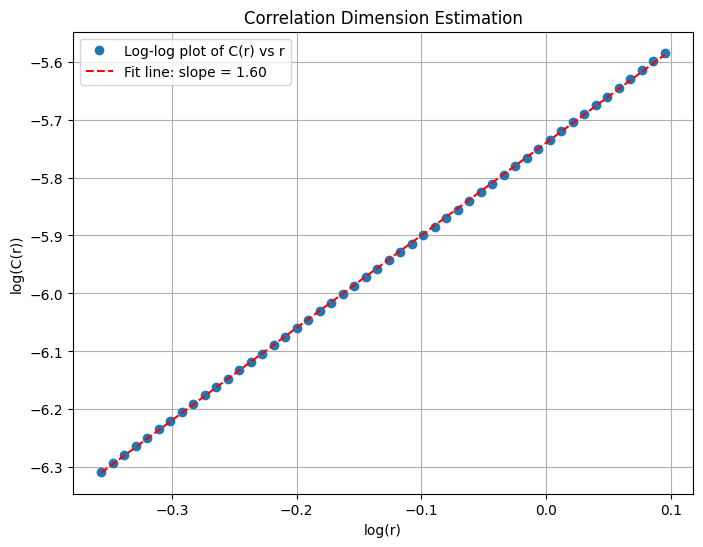

KL-Lipschitz=1 GPA: MSE=0.15060025192318452


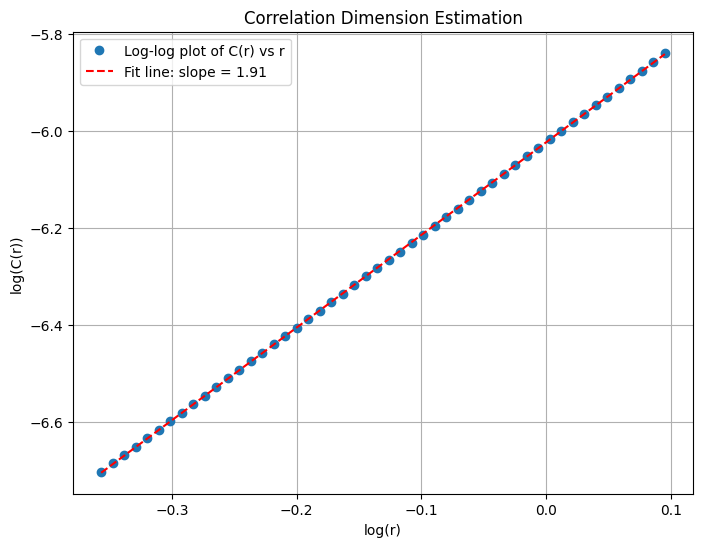

alpha=2 GPA: MSE=0.15060025192318452


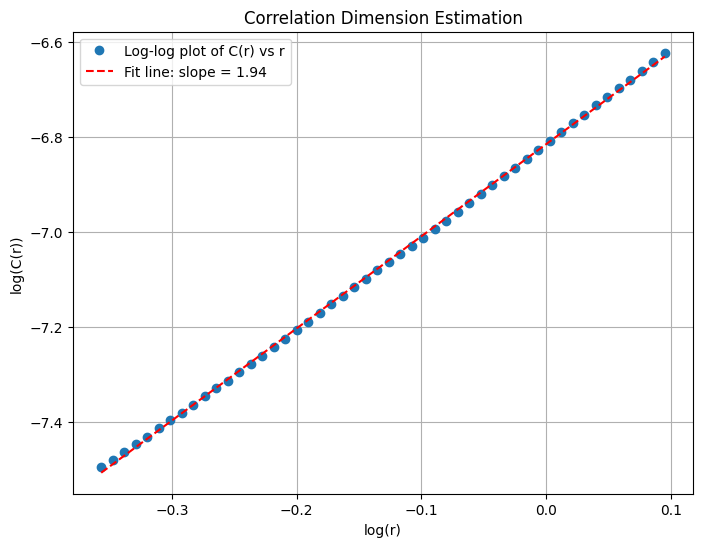

KL GPA: MSE=0.15060025192318452


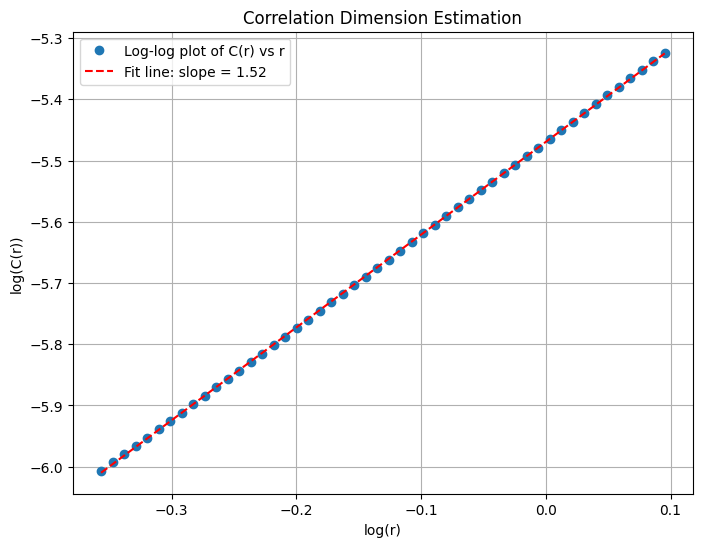

1000 samples
alpha=2-Lipschitz=1 GPA: MSE=0.15060025192318452


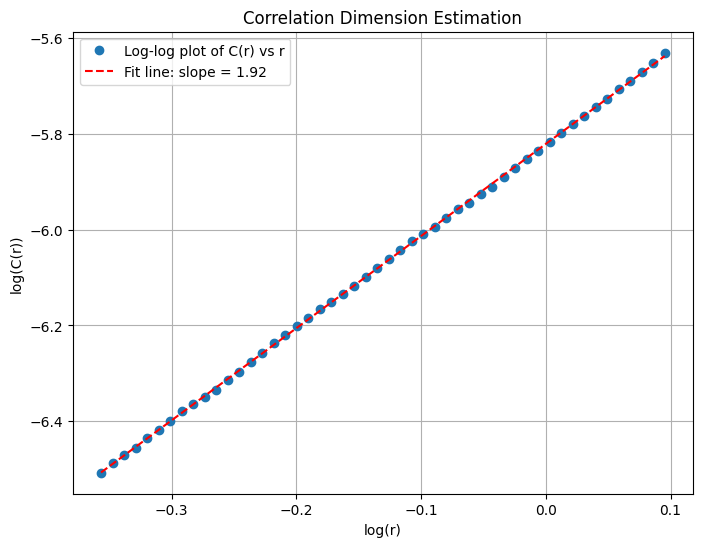

KL-Lipschitz=1 GPA: MSE=0.15060025192318452


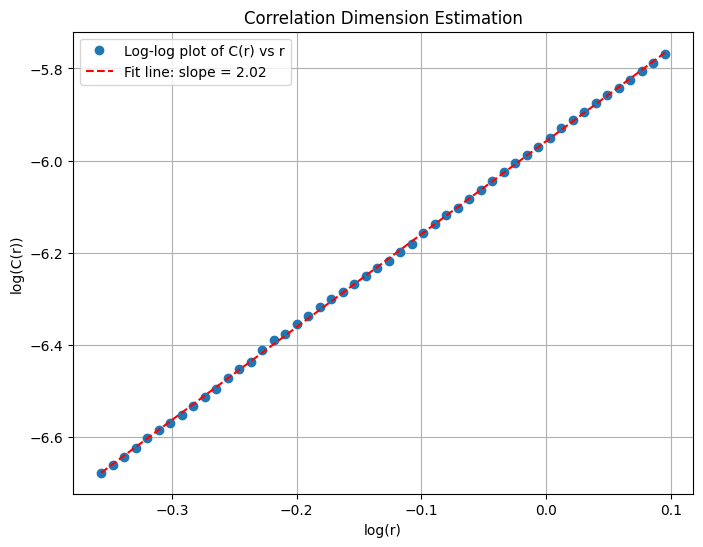

alpha=2 GPA: MSE=0.15060025192318452


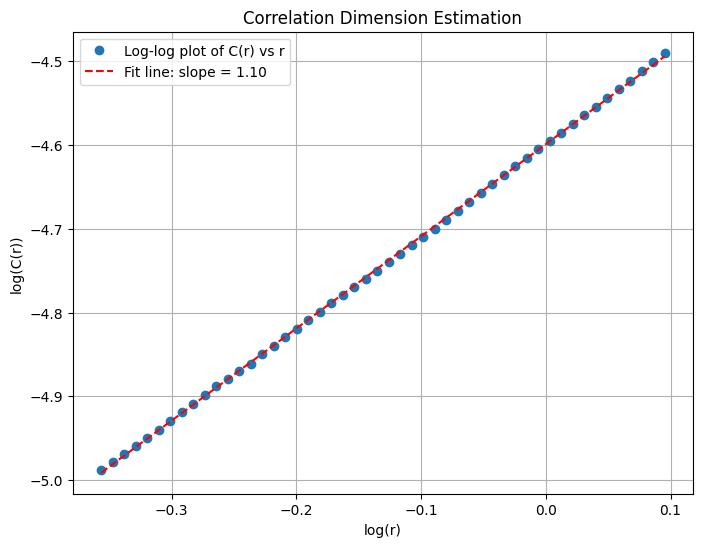

KL GPA: MSE=0.15060025192318452


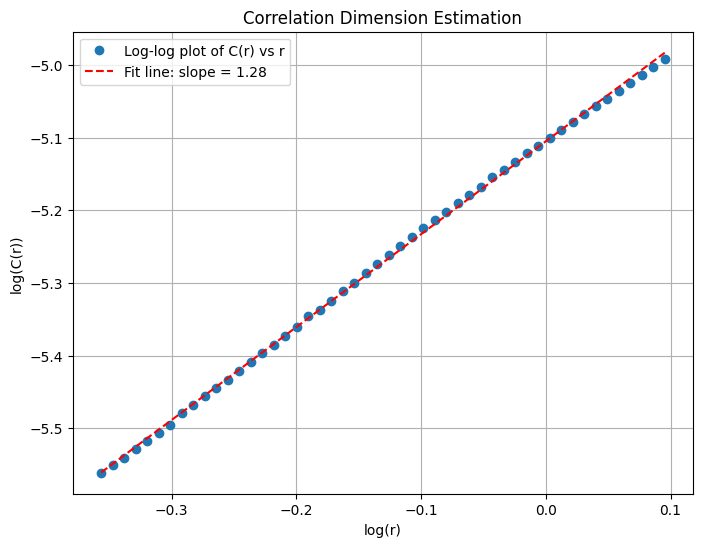

In [8]:
Ds = ['alpha=02.00-Lipschitz_1.0000', 'KL=02.00-Lipschitz_1.0000', 'alpha=02.00-Lipschitz_inf', 'KL=02.00-Lipschitz_inf']
D_names = ["alpha=2-Lipschitz=1 GPA", "KL-Lipschitz=1 GPA", "alpha=2 GPA", "KL GPA"]

print("5000 samples")
for D, D_name in zip(Ds, D_names):
    
    filename = "assets/Lorenz63/%s_5000_10000_00_3.pickle" % (D)

    with open(filename, "rb") as fr:
        param, result = pickle.load(fr)

    print(f"{D_name}: MSE={mse(generated)}")
    radii, correlation_sum, dimension_estimate = estimate_correlation_dimension(result['trajectories'][-1], min_radius=0.7, max_radius=1.1)


print("1000 samples")
for D, D_name in zip(Ds, D_names):
    
    filename = "assets/Lorenz63/%s_1000_2000_00_3.pickle" % (D)

    with open(filename, "rb") as fr:
        param, result = pickle.load(fr)
        
    print(f"{D_name}: MSE={mse(generated)}")
    radii, correlation_sum, dimension_estimate = estimate_correlation_dimension(result['trajectories'][-1], min_radius=0.7, max_radius=1.1)



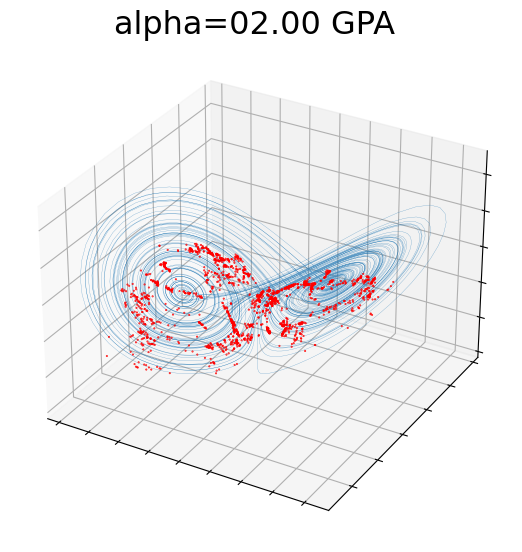

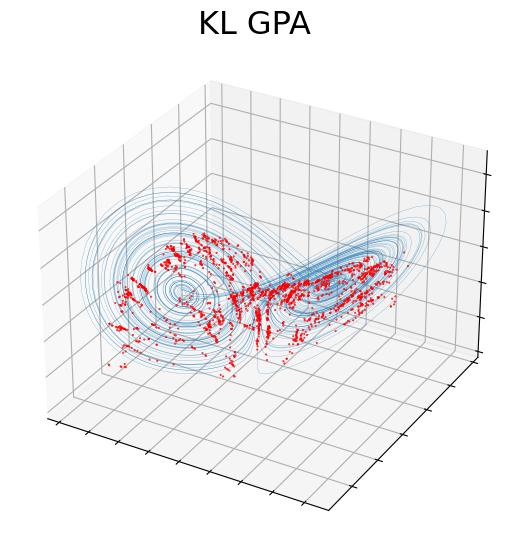

In [9]:
# Lipschitz regularized GPA (Light to Heavy)

fs = ['alpha=02.00', 'KL']# 'reverse_KL', ]

for f in fs:
    if f in ['KL', 'reverse_KL']:
        alias_f = f + '=02.00'
    else:
        alias_f = f
    filename = "assets/Lorenz63/%s-Lipschitz_inf_1000_2000_00_3.pickle" % (alias_f)

    with open(filename, "rb") as fr:
        param, result = pickle.load(fr)
        
    #make_animation(result['trajectories'][-1], f+" GPA (1000 samples)")
    make_figure(result['trajectories'][-1], f+" GPA (1000 samples)")
    #make_figure(result['trajectories'][-1],f+" GPA (1000 samples)", [62,130, 0])
    #make_figure(result['trajectories'][-1],f+" GPA (1000 samples)", [119,120, 0])


0.4676668591876053


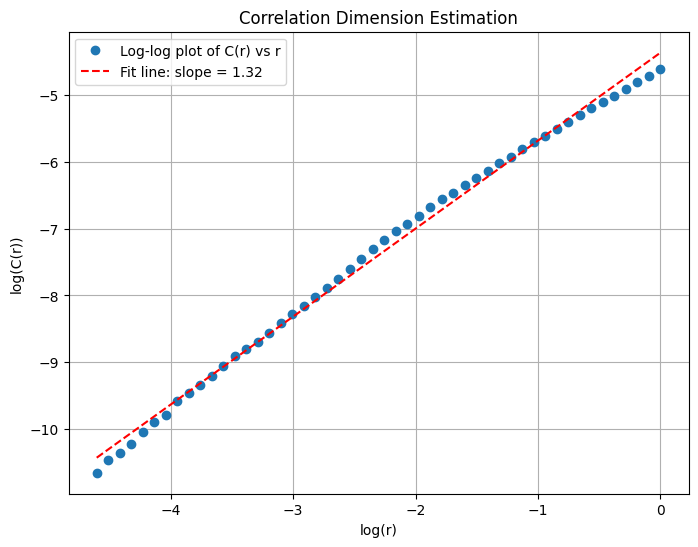

0.6535750716788629


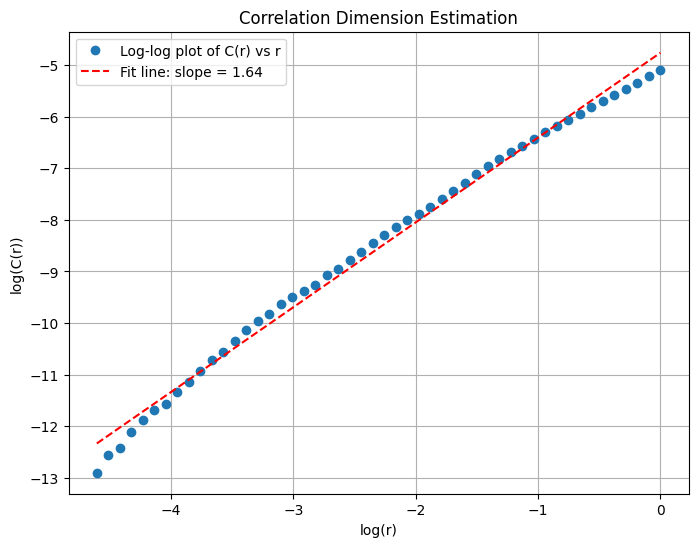

In [10]:
# Lipschitz regularized GPA (Light to Heavy)

fs = ['alpha=02.00', 'KL']# 'reverse_KL', ]

for f in fs:
    if f in ['KL', 'reverse_KL']:
        alias_f = f + '=02.00'
    else:
        alias_f = f
    filename = "assets/Lorenz63/%s-Lipschitz_inf_1000_2000_00_3.pickle" % (alias_f)

    with open(filename, "rb") as fr:
        param, result = pickle.load(fr)
        
    print(mse(result['trajectories'][-1]))
    radii, correlation_sum, dimension_estimate = estimate_correlation_dimension(result['trajectories'][-1], min_radius=1e-2)

## W2 proximals (flow models)

### OT flow vs CNF
$$\inf_{T: \mathbb{R}^d \rightarrow \mathbb{R}^d} D_{KL}(Q\|T_{\#}P) + C W_2^2(P, T_{\#}P)$$
vs
$$\inf_{T: \mathbb{R}^d \rightarrow \mathbb{R}^d} D_{KL}(Q\|T_{\#}P)$$

5000 samples


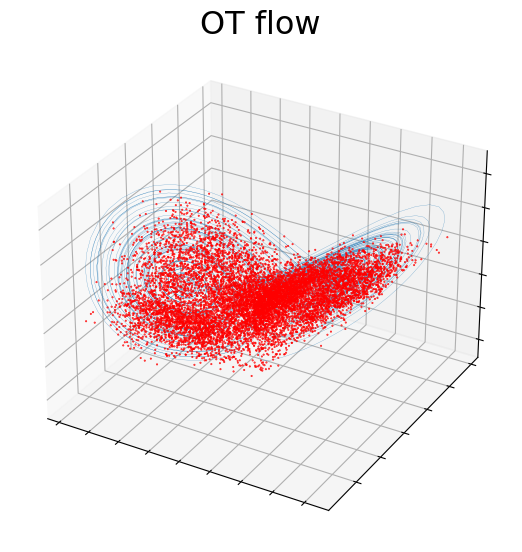

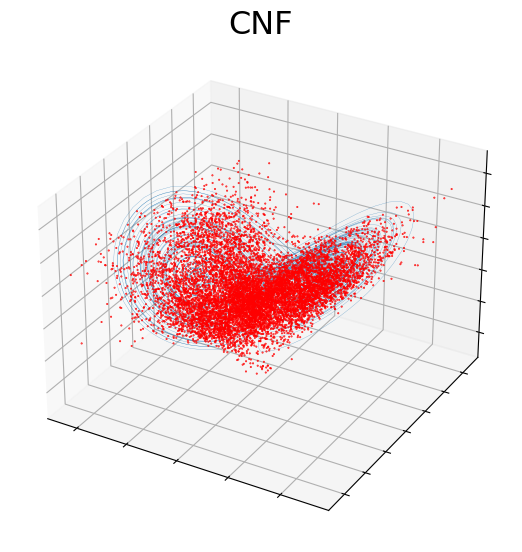

1000 samples


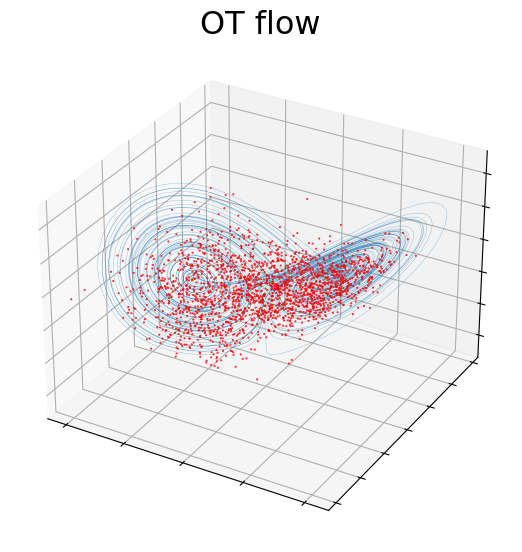

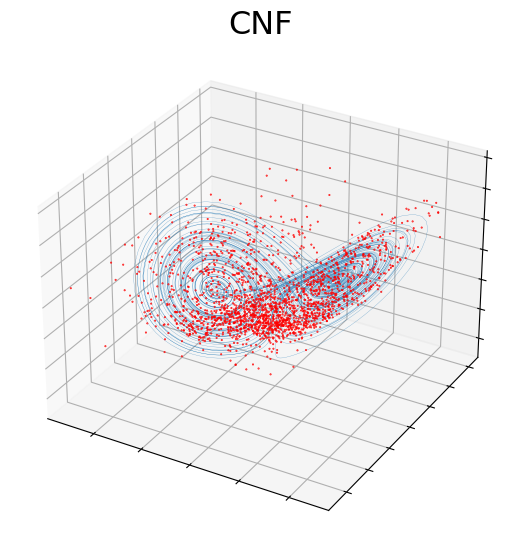

In [11]:
Ds = ['otflow', 'no_otflow']
D_names = ["OT flow", "CNF"]

print("5000 samples")
for D, D_name in zip(Ds, D_names):
    filename = f"assets/Lorenz63/{D}_5000samples.pickle"
    with open(filename, "rb") as fr:
        [normalized, generated] = pickle.load(fr)
        
    #make_animation(generated[:10000], D_name)
    make_figure(generated[:10000], D_name)
    #make_figure(generated[:10000], D_name, [62,130, 0])
    #make_figure(generated[:10000], D_name, [119,120, 0])


print("1000 samples")
for D, D_name in zip(Ds, D_names):
    filename = f"assets/Lorenz63/{D}_1000samples.pickle"
    with open(filename, "rb") as fr:
        [normalized, generated] = pickle.load(fr)
        
    #make_animation(generated[:10000], D_name)
    make_figure(generated[:10000], D_name)
    #make_figure(generated[:10000], D_name, [62,130, 0])
    #make_figure(generated[:10000], D_name, [119,120, 0])


5000 samples
OT flow: MSE=0.6231108678200421


/Users/hyemin/Documents/source_code/Proximal_generative_models/Lorenz63/correlation_dimension.py:38: RuntimeWarning: divide by zero encountered in log
  log_corr_sum = np.log(correlation_sum)


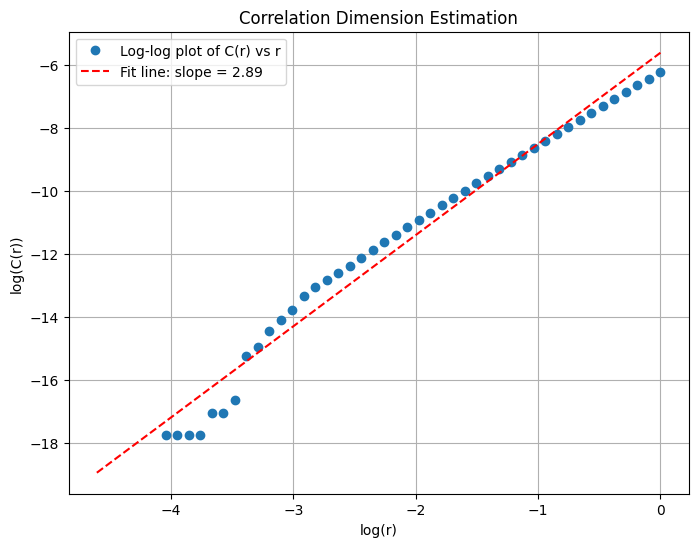

CNF: MSE=1.2674031766986205


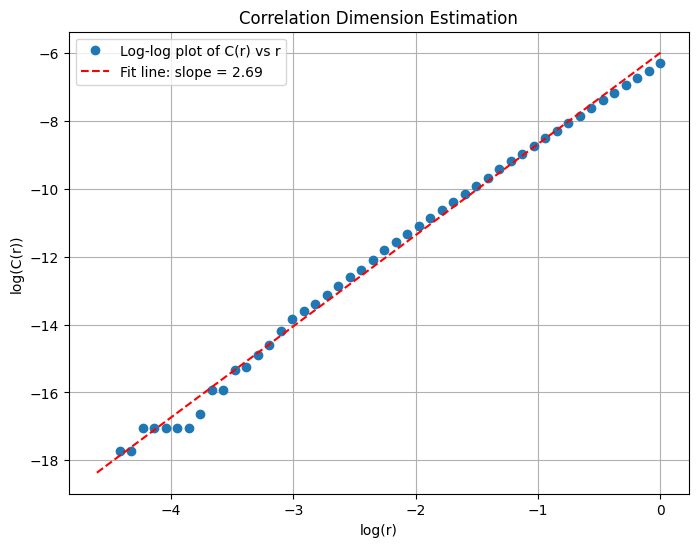

1000 samples
OT flow: MSE=1.6267423358595436


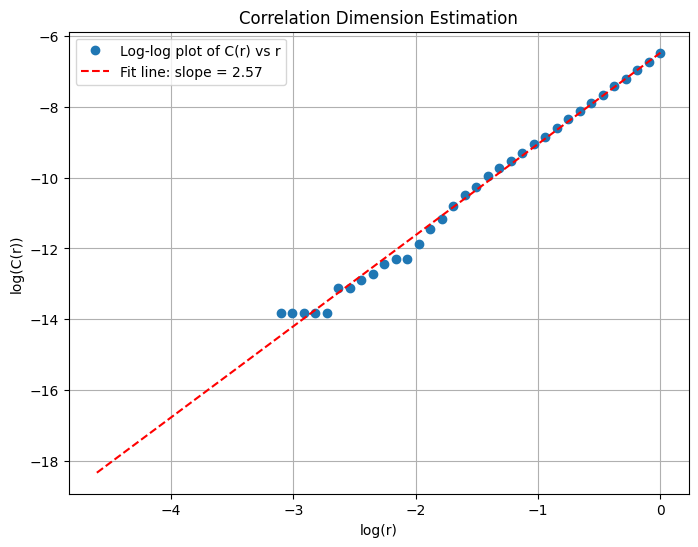

CNF: MSE=2.6640980280052373


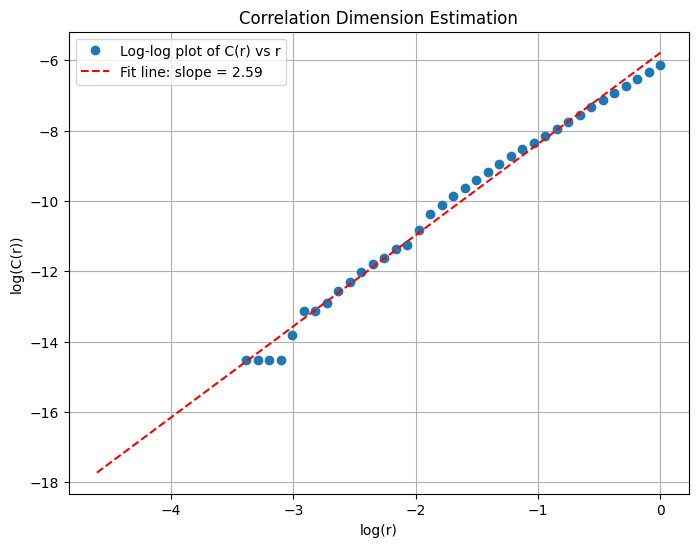

In [12]:
Ds = ['otflow', 'no_otflow']
D_names = ["OT flow", "CNF"]

print("5000 samples")
for D, D_name in zip(Ds, D_names):
    filename = f"assets/Lorenz63/{D}_5000samples.pickle"
    with open(filename, "rb") as fr:
        [normalized, generated] = pickle.load(fr)
        
    print(f"{D_name}: MSE={mse(generated)}")
    radii, correlation_sum, dimension_estimate = estimate_correlation_dimension(generated, min_radius=1e-2)
    


print("1000 samples")
for D, D_name in zip(Ds, D_names):
    filename = f"assets/Lorenz63/{D}_1000samples.pickle"
    with open(filename, "rb") as fr:
        [normalized, generated] = pickle.load(fr)
        
    print(f"{D_name}: MSE={mse(generated)}")
    radii, correlation_sum, dimension_estimate = estimate_correlation_dimension(generated, min_radius=1e-2)
    

## Variance Exploding (VE) SGM 
$$\inf_R -E_R(\log Q) + \int_0^T \int_{\mathbb{R}^d} \left(\frac{1}{2}|v(x,t)|^2 - \nabla \cdot f (x,t) \right) \rho(x,t)dx dt$$
where $f=0$ is the drift of diffusion process.

5000 samples


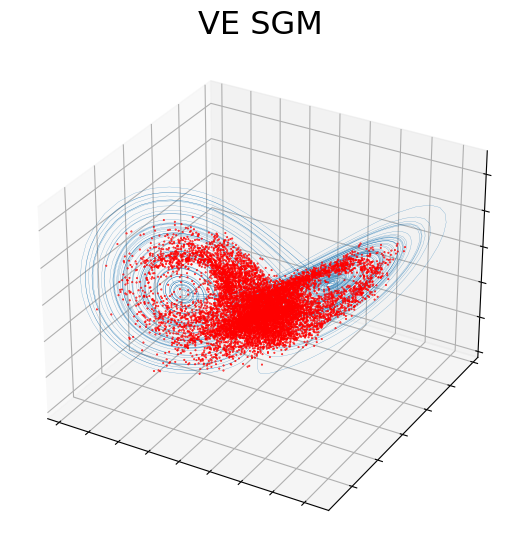

1000 samples


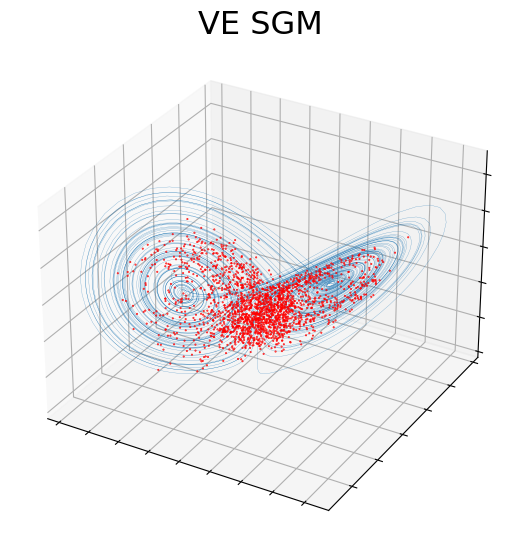

In [13]:
print("5000 samples")
filename = f"assets/Lorenz63/ve_sgm_5000samples.pickle"
with open(filename, "rb") as fr:
    reverse_ode, reverse_sde = pickle.load(fr)

#make_animation(reverse_ode, "VE SGM")
make_figure(reverse_ode, "VE SGM")
#make_figure(reverse_ode,"VE SGM", [62,130, 0])
#make_figure(reverse_ode,"VE SGM", [119,120, 0])

print("1000 samples")
filename = f"assets/Lorenz63/ve_sgm_1000samples.pickle"
with open(filename, "rb") as fr:
    reverse_ode, reverse_sde = pickle.load(fr)

#make_animation(reverse_ode, "VE SGM")
make_figure(reverse_ode, "VE SGM")
#make_figure(reverse_ode,"VE SGM", [62,130, 0])
#make_figure(reverse_ode,"VE SGM", [119,120, 0])


5000 samples
CNF: MSE=2.6640980280052373


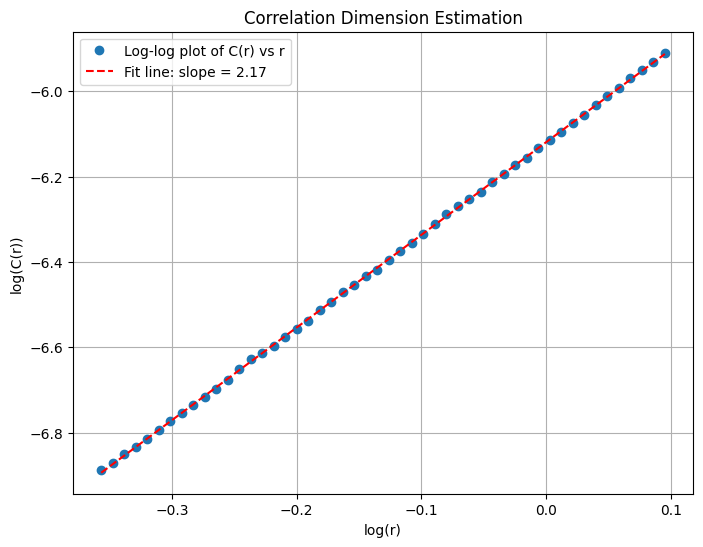

1000 samples
CNF: MSE=2.6640980280052373


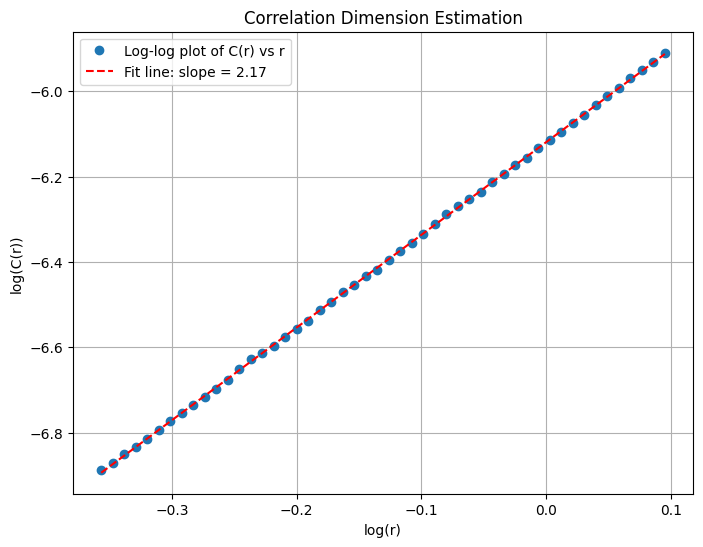

In [14]:
print("5000 samples")
filename = f"assets/Lorenz63/ve_sgm_5000samples.pickle"
with open(filename, "rb") as fr:
    reverse_ode, reverse_sde = pickle.load(fr)

print(f"{D_name}: MSE={mse(generated)}")
radii, correlation_sum, dimension_estimate = estimate_correlation_dimension(generated, min_radius=0.7, max_radius=1.1)

print("1000 samples")
filename = f"assets/Lorenz63/ve_sgm_1000samples.pickle"
with open(filename, "rb") as fr:
    reverse_ode, reverse_sde = pickle.load(fr)

print(f"{D_name}: MSE={mse(generated)}")
radii, correlation_sum, dimension_estimate = estimate_correlation_dimension(generated, min_radius=0.7, max_radius=1.1)
